In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# import targetsets from folder
bcf_mordred_full_manual_polar = pd.read_csv('data/targetset/bcf_mordred_full_manual_polar.csv', index_col=0)

In [3]:
# Transfer learning data preparation
def get_data(dataframe):
    """Partition data into training dataset, target dataset, and global pfas dataset"""
    df_training = dataframe[dataframe['Category'] == 0]
    df_target = dataframe[dataframe['Category'] == 1]
    df_pfas = dataframe[dataframe['Category'] == 2]

    data1 = df_training.drop(columns=['Category'], axis=1)
    data2 = df_target.drop(columns=['Category'], axis=1)
    data3 = df_pfas.drop(columns=['Category'], axis=1)

    y_train = data1.pop('logBCF').to_numpy()
    X_train = data1.to_numpy()

    y_target = data2.pop('logBCF').to_numpy()
    X_target = data2.to_numpy()

    y_pfas = data3.pop('logBCF').to_numpy()
    X_pfas = data3.to_numpy()
    
    return X_train, y_train, X_target, y_target, X_pfas, y_pfas

In [4]:
class DNN(keras.Model):
    def __init__(self, n_layers=4, layer_size=200, batch_size=250, learning_rate=0.01, epochs=1000, seed=100):
        super().__init__()
        self.n_layers = n_layers
        self.layer_size = layer_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.seed = seed
        self.generate()
    
    def generate(self):
        self.pipeline = []
        
        for i, layer in enumerate(range(self.n_layers)):
            # batch normalization improves stability of model
            self.pipeline.append(layers.BatchNormalization())
            self.pipeline.append(layers.Dense(self.layer_size, activation='relu'))
            
        self.pipeline.append(layers.BatchNormalization())
        self.pipeline.append(layers.Dense(1, activation = 'linear'))
        
    def call(self, inputs):
        x = inputs
        for layer in self.pipeline:
            x = layer(x)
            
        return x
        
    def fit(self, x_train, y_train, **kwargs):
        tf.random.set_seed(self.seed)
        
        # build creates input layer based on training data shape
        super().build(input_shape=x_train.shape)
        super().compile(optimizer=keras.optimizers.Adam(self.learning_rate), loss='mean_squared_error', 
                        metrics=['mse', 'mae'])
        return super().fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, **kwargs)
    
# for reinitializing layers
def init_layer(layer):
    if hasattr(layer, 'cell'):
        init_container = layer.cell
    else:
        init_container = layer

    for key, initializer in init_container.__dict__.items():
        if "initializer" not in key: # is this item an initializer?
            continue # if no, skip it

        # find the corresponding variable, like the kernel or the bias
        if key == 'recurrent_initializer': #special case check
            var = getattr(init_container, 'recurrent_kernel')
        else:
            var = getattr(init_container, key.replace("_initializer", ""))

        var.assign(initializer(var.shape, var.dtype))

# print out all validation metrics
def summarize(title, val, global_val):
    print('--------------------')
    print(title)
    print('Cross-Validation Metrics:')
    print('--------------------')
    print('Mean r2:', np.mean(val['r2']))
    print('Mean mae:', np.mean(val['mae']))
    print('Mean rmse:', np.mean(val['rmse']), '\n')
    
    print('PFAS Ensemble Metrics:')
    print('--------------------')
    print('r2:', global_val['r2'][0])
    print('mae:', global_val['mae'][0])
    print('rmse:', global_val['rmse'][0])
    
def plot_history(history, title=''):
    plt.plot(history.history['mse'], label='Train')
    plt.plot(history.history['val_mse'], label='Validation')

    plt.title('Loss v. Epoch' + title)
    plt.ylabel('MSE')
    plt.xlabel('Epoch')

    plt.legend(loc='upper right')
    plt.show()
    
def plot_histories(histories):
    for fold, history in enumerate(histories):
        plot_history(history, title=': Fold ' + fold)

# Base DNN Model

* Train optimized base model for transfer learning
* Ensemble of 5 models used for global validation
* Tag is identifier for specific target set

In [5]:
def base_dnn(X_base, y_base, X_target, y_target, X_pfas, y_pfas, learning_rate, n_layers, layer_size, batch_size, tag='default'):
    
    # make file directories
    Path(f'./model/{tag}').mkdir(parents=True, exist_ok=True)
    Path(f'./results/{tag}').mkdir(parents=True, exist_ok=True)
    
    ensemble1 = []
    ensemble2 = []
    histories = []
    validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    global_validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    
    kf = KFold(n_splits=5, shuffle=True, random_state=200)
    for fold_no, (train, test) in enumerate(kf.split(X_base)):
        print("Starting: Fold", fold_no)
        X_train, y_train = X_base[train], y_base[train]
        X_test, y_test = X_base[test], y_base[test]

        model = DNN(learning_rate=learning_rate, n_layers=n_layers, layer_size=layer_size, batch_size=batch_size)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=100,
                                                          monitor='val_loss',
                                                          mode='min',
                                                          restore_best_weights=True)
        
        history = model.fit(X_train, 
                            y_train, 
                            callbacks=[early_stopping], 
                            validation_data=(X_test, y_test), 
                            verbose=0)
        
        histories.append(history)

        # save weights
        model.save_weights(f'model/{tag}/dnn_base_{fold_no}_{tag}', overwrite=True)

        # validation predictions on PFAS-like excluded
        y_pred = model.predict(X_test)
        
        # export results
        results = pd.DataFrame({
            'y_actual': y_test,
            'y_pred': y_pred,
        })   
        results.to_csv(f'results/{tag}/dnn_base_{fold_no}_{tag}')
        
        # validation metrics r2, mae, mse for fold
        validation_metrics['r2'].append(r2_score(y_test, y_pred))
        validation_metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        validation_metrics['rmse'].append(mean_squared_error(y_test, y_pred, squared=False))

        # global validation prediction
        y_pfas_pred = model.predict(X_pfas)
        y_target_pred = model.predict(X_target)
        ensemble1.append(y_pfas_pred)
        ensemble2.append(y_target_pred)
    
    # ensemble pooling global validation prediction
    ensemble1_pred = np.mean(ensemble1, axis=0)
    ensemble2_pred = np.mean(ensemble2, axis=0)
    global_validation_metrics['r2'].append(r2_score(y_pfas, ensemble1_pred))
    global_validation_metrics['mae'].append(mean_absolute_error(y_pfas, ensemble1_pred))
    global_validation_metrics['rmse'].append(mean_squared_error(y_pfas, ensemble1_pred, squared=False))
    
    # export results
    results1 = pd.DataFrame({
        'y_actual': y_pfas,
        'y_pred': ensemble1_pred,
    })    
    results2 = pd.DataFrame({
        'y_actual': y_target,
        'y_pred': ensemble2_pred,
    })
    results1.to_csv(f'results/{tag}/dnn_base_pfas_{tag}')
    results2.to_csv(f'results/{tag}/dnn_base_target_{tag}')
        
    return validation_metrics, global_validation_metrics, histories

def run_base(dataframe, learning_rate=0.01, n_layers=8, layer_size=200, batch_size=128, tag='default'):
    base_metrics, global_base_metrics, histories = base_dnn(*get_data(dataframe), 
                                                          learning_rate, 
                                                          n_layers,
                                                          layer_size,
                                                          batch_size,
                                                          tag=tag)
    summarize('Base DNN Model: ' + tag, base_metrics, global_base_metrics)
    plot_histories(histories)

# Training the Base Model

First create the base model by feeding the `run_base(dataframe, learning_rate, n_layers, layer_size, batch_size, tag='', export=True)` function the targetset dataframe, the corresponding tuned DNN hyperparameters, and a string identifier tag. Make sure to save the scalers used by the base model for the transfer model.

To do: make it output training and validation loss plot, to see whether convergence has happened and to use information to adjust settings to early stopping patience or to increase number of training epochs.

In [6]:
run_base(bcf_mordred_full_manual_polar, learning_rate=0.01, n_layers=5, layer_size=1024, batch_size=128, tag='mfmp')

Starting: Fold 0
Starting: Fold 1
Starting: Fold 2
Starting: Fold 3
Starting: Fold 4
--------------------
Base DNN Model: mfmp
Cross-Validation Metrics:
--------------------
Mean r2: 0.6649085782738609
Mean mae: 0.5891403008484644
Mean rmse: 0.7889154115258009 

PFAS Ensemble Metrics:
--------------------
r2: -0.29642690719467146
mae: 1.3602620516398738
rmse: 1.86552753909685


# Transfer DNN Model

In [9]:
# Transfer learning model

def transfer_dnn(X_base, y_base, X_target, y_target, X_pfas, y_pfas, learning_rate, epochs, fine_tune_at, init, export=True, verbose=False, tag='default'):
    ensemble = []
    histories = []
    validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    global_validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    
    kf = KFold(n_splits=5, shuffle=True, random_state=200)
    for fold_no, (train, test) in enumerate(kf.split(X_target)):
        if verbose:
            print("Starting: Fold", fold_no)
            
        X_train, y_train = X_target[train], y_target[train]
        X_test, y_test = X_target[test], y_target[test]
        
        # load base model
        model = DNN(learning_rate=learning_rate, n_layers=9, layer_size=200, batch_size=512)
        model.build(input_shape=X_train.shape)
        model.load_weights(f'model/{tag}/dnn_mordred_base_{fold_no}_{tag}'.expect_partial())

        # make modifications to base model
        model.epochs = epochs

        # freeze first initial layers
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False
            
        # reinitialize layers (randomize weights)
        if init == 1:
            for layer in model.layers[fine_tune_at:]:
                init_layer(layer)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=100,
                                                          monitor='val_loss',
                                                          mode='min',
                                                          restore_best_weights=True)
        
        history = model.fit(X_train, 
                            y_train, 
                            callbacks=[early_stopping], 
                            validation_data=(X_test, y_train), 
                            verbose=0)
        histories.append(history)
        
        y_pred = model.predict(X_test)
        
        # export predictions
        if export:
            results = pd.DataFrame({
                'y_actual': y_test,
                'y_pred': y_pred,
            })   
            results.to_csv(f'results/{tag}/dnn_transfer_{fold_no}_{tag}')

        # global validation prediction
        y_pfas_pred = model.predict(X_pfas)
        ensemble.append(y_pfas_pred)

        # Calculate metrics r2, mae, rmse for fold
        validation_metrics['r2'].append(r2_score(y_test, y_pred.))
        validation_metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        validation_metrics['rmse'].append(mean_squared_error(y_test, y_pred, squared=False))
    
    ensemble_pred = np.mean(ensemble, axis=0)
    global_validation_metrics['r2'].append(r2_score(y_pfas, ensemble_pred))
    global_validation_metrics['mae'].append(mean_absolute_error(y_pfas, ensemble_pred))
    global_validation_metrics['rmse'].append(mean_squared_error(y_pfas, ensemble_pred, squared=False))
    
    if export:
        results = pd.DataFrame({
            'y_actual': y_pfas,
            'y_pred': ensemble_pred,
        })   
        results.to_csv(f'results/{tag}/dnn_transfer_{tag}')
        
    return validation_metrics, global_validation_metrics, histories

def run_transfer(dataframe, scalers, learning_rate=0.0001, epochs=1000, fine_tune_at=6, init=1, export=True, verbose=False, tag='default'):
    transfer_metrics, global_transfer_metrics, histories = transfer_dnn(*get_data(dataframe), 
                                                             scalers,
                                                             learning_rate, 
                                                             n_layers,
                                                             layer_size,
                                                             batch_size,
                                                             export=export,
                                                             verbose=verbose,
                                                             tag=tag)
    summarize('Transfer DNN Model: ' + tag, transfer_metrics, global_transfer_metrics)
    plot_histories(histories)

# Transfer Hyperparameter Tuning

Before creating the final transfer learning model, we must tune the hyperparameters to get the best validation score on the target set. This will be done through a grid search.

In [10]:
# Hyperparameter tuning:
# Grid search of layer to freeze, reinitialize, learning rate, epochs
grid = {'epochs': [250, 500, 750, 1000], 
        'learning_rate': [0.001, 0.0001, 0.00001], 
        'fine_tune_at': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18],
        'init': [0, 1]} # 0 - true, 1 - false

# return hyperparameters that give lowest training validation r2 OR lowest global validation r2
def gridsearch(dataframe, grid, tag=''):    
    # get list of all possible combinations of indices from each list
    X_base, y_base, X_target, y_target, X_pfas, y_pfas = get_data(dataframe)
    combination = 1
    best = {'score': np.inf, 'val': None, 'global_val': None}
    best_params = dict.fromkeys(list(grid.keys()))
    
    total_combinations = len(list(itertools.product(*list(grid.values()))))
    print("Total search combinations:", total_combinations)
    for epochs, learning_rate, fine_tune_at, init in itertools.product(*list(grid.values())):
        print("Searching combination", combination, "of", total_combinations)
        transfer_metrics, global_metrics, histories = transfer_dnn(X_base, y_base, X_target, y_target, X_pfas, y_pfas, 
                                                        learning_rate,
                                                        epochs,
                                                        fine_tune_at, 
                                                        init,
                                                        export=False,
                                                        verbose=False, 
                                                        tag=tag) 
        
        # minimize mean mse
        score = np.mean([x**2 for x in transfer_metrics['rmse']])
        
        if score < best['score']:
            best['score'] = score
            best['val'] = transfer_metrics
            best['global_val'] = global_metrics
            best_params['epochs'] = epochs
            best_params['learning_rate'] = learning_rate
            best_params['fine_tune_at'] = fine_tune_at
            best_params['init'] = init

        combination += 1
    
    return best, best_params

def run_gridsearch(dataframe, grid, tag='default'):
    best, best_params = gridsearch(dataframe, grid, tag=tag)
    print('--------------------')
    print('Best MSE Score:', best['score'])
    print(best_params)
    summarize('Transfer-tuned DNN Model: ' + tag, best['val'], best['global_val'])

To properly run transfer hyperparameter tuning, first make sure that the base model has been created so that its weights have been saved. Then provide the targetset dataframe, the scalers from the base model, and the identifier to `run_gridsearch(dataframe, scalers, grid, tag='')`.

In [ ]:
run_gridsearch(targetset, grid, tag='e')

# Training the Final Transfer Model

Similar to before with the base model, create the final transfer model by feeding the `run_transfer(dataframe, scalers, learning_rate, epochs, fine_tune_at, init, export=True, verbose=False, tag='')` function the targetset dataframe, the corresponding tuned transfer hyperparameters, and a string identifier tag. Input the scalers returned by the base model.

In [ ]:
run_transfer(targetset, learning_rate=0.0001, epochs=1000, fine_tune_at=6, init=1, tag='e')

# Regression Plots 

To produce the regression plots, make sure that `run_base()` and `run_transfer()` have both been run with the same exact string identifier tag, e.g. `tag='e'`. Then simply run `regression_plot(tag='e')`.

In [20]:
# for given tag, summarize all model performances for comparison, make regression plot
def regression_plot(tag='default'):
    
    def get_metrics(results):
        y1 = results['y_actual']
        y2 = results['y_pred']
        # r2, mae, rmse
        r2 = str(round(r2_score(y1, y2), 2))
        mae = str(round(mean_absolute_error(y1, y2), 2))
        rmse = str(round(mean_squared_error(y1, y2, squared=False), 2))
        
        return 'MAE={}, $R^2$={}, RMSE={}'.format(mae, r2, rmse)
        
    # five folds for base model
    base_results = pd.DataFrame()
    for fold_no in range(0, 5):
        br = pd.read_csv(f'results/{tag}/dnn_base_{fold_no}_{tag}', index_col=0)
        base_results = pd.concat([base_results, br], ignore_index=True)
    
    # base target
    base_target_results = pd.read_csv(f'results/{tag}/dnn_base_target_{tag}', index_col=0)
    
    # base pfas
    base_pfas_results = pd.read_csv(f'results/{tag}/dnn_base_pfas_{tag}', index_col=0)
    
    # five folds for transfer model
    transfer_results = pd.DataFrame()
    for fold_no in range(0, 5):
        tr = pd.read_csv(f'results/{tag}/dnn_transfer_{fold_no}_{tag}', index_col=0)
        transfer_results = pd.concat([transfer_results, tr], ignore_index=True)
    
    # transfer pfas
    transfer_pfas_results = pd.read_csv(f'results/{tag}/dnn_transfer_{tag}', index_col=0)
    
    # regression plots
    fig, axes = plt.subplots(3, 2, figsize=(12, 18), dpi=72)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.rc('figure', facecolor='white')
    plt.rc('font', family='Arial', weight='normal')
    plt.rc('axes', labelsize=22, facecolor='white')
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=20)
    
    axes[0][0].scatter(base_results['y_actual'], base_results['y_pred'], s=20,
                alpha = 0.5, color='darkblue')
    axes[0][0].plot([0,1],[0,1], transform=axes[0][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[0][0].set_title('DNN-Base-Source\n' + get_metrics(base_results))
    axes[0][0].set_xlabel("Actual")
    axes[0][0].set_ylabel("Prediction")
    axes[0][0].set_xlim((-1, 6.5))
    axes[0][0].set_ylim((-1, 6.5))
    axes[0][0].set_xticks([0,1,2,3,4,5,6])
    axes[0][0].set_yticks([0,1,2,3,4,5,6])
    
    axes[1][0].scatter(base_target_results['y_actual'], base_target_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[1][0].plot([0,1],[0,1], transform=axes[1][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[1][0].set_title('DNN-Base-Target\n' + get_metrics(base_target_results))
    axes[1][0].set_xlabel("Actual")
    axes[1][0].set_ylabel("Prediction")
    axes[1][0].set_xlim((-1, 6.5))
    axes[1][0].set_ylim((-1, 6.5))
    axes[1][0].set_xticks([0,1,2,3,4,5,6])
    axes[1][0].set_yticks([0,1,2,3,4,5,6])
    
    axes[2][0].scatter(base_pfas_results['y_actual'], base_pfas_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[2][0].plot([0,1],[0,1], transform=axes[2][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[2][0].set_title('DNN-Base-PFAS\n' + get_metrics(base_pfas_results))
    axes[2][0].set_xlabel("Actual")
    axes[2][0].set_ylabel("Prediction")
    axes[2][0].set_xlim((-1, 6.5))
    axes[2][0].set_ylim((-1, 6.5))
    axes[2][0].set_xticks([0,1,2,3,4,5,6])
    axes[2][0].set_yticks([0,1,2,3,4,5,6])
    
    axes[1][1].scatter(transfer_results['y_actual'], transfer_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[1][1].plot([0,1],[0,1], transform=axes[1][1].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[1][1].set_title('DNN-Transfer-Target\n' + get_metrics(transfer_results))
    axes[1][1].set_xlabel("Actual")
    axes[1][1].set_ylabel("Prediction")
    axes[1][1].set_xlim((-1, 6.5))
    axes[1][1].set_ylim((-1, 6.5))
    axes[1][1].set_xticks([0,1,2,3,4,5,6])
    axes[1][1].set_yticks([0,1,2,3,4,5,6])
    
    axes[2][1].scatter(transfer_pfas_results['y_actual'], transfer_pfas_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[2][1].plot([0,1],[0,1], transform=axes[2][1].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[2][1].set_title('DNN-Transfer-PFAS\n' + get_metrics(transfer_pfas_results))
    axes[2][1].set_xlabel("Actual")
    axes[2][1].set_ylabel("Prediction")
    axes[2][1].set_xlim((-1, 6.5))
    axes[2][1].set_ylim((-1, 6.5))
    axes[2][1].set_xticks([0,1,2,3,4,5,6])
    axes[2][1].set_yticks([0,1,2,3,4,5,6])
    
    fig.delaxes(axes[0][1])

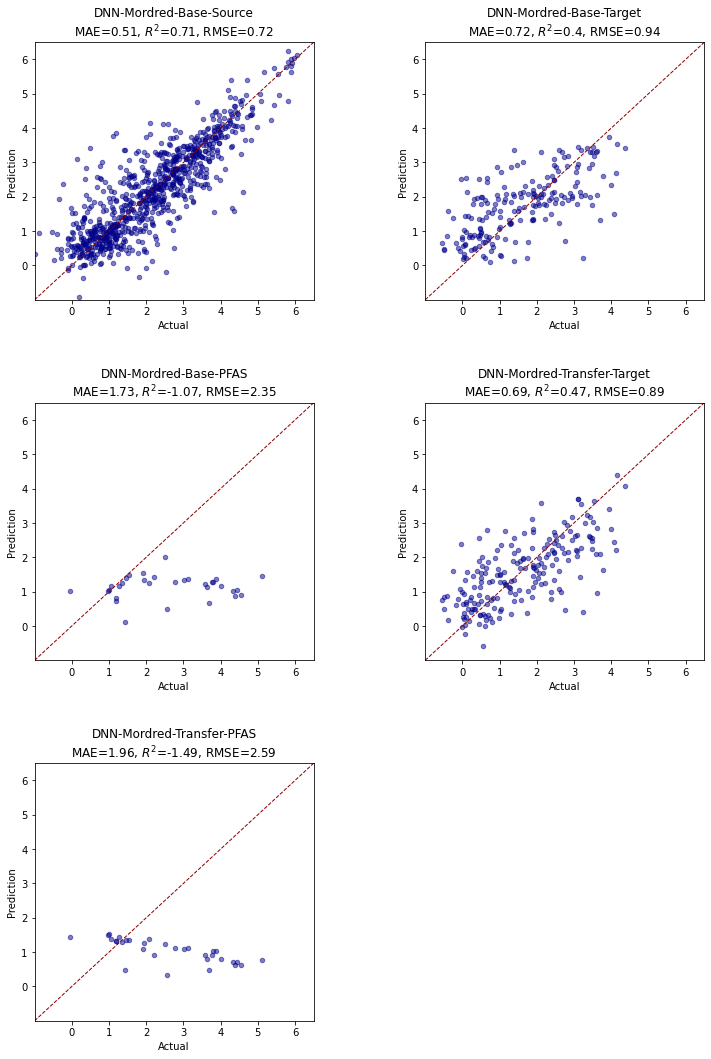

In [16]:
regression_plot(tag='e')